In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.cross_validation import cross_val_score as cv
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data['MrMrs'] = data['Name'].apply(lambda x: int('Mr' in x))
test_data['MrMrs'] = test_data['Name'].apply(lambda x: int('Mr' in x))
data = data.drop(['Name','Ticket'],axis=1)
test_data = test_data.drop(['Name','Ticket'],axis=1)

data.head()
test_data.head()

/home/fotol/4year/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/fotol/4year/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,MrMrs
0,892,3,male,34.5,0,0,7.8292,NaN,Q,1
1,893,3,female,47.0,1,0,7.0000,NaN,S,1
2,894,2,male,62.0,0,0,9.6875,NaN,Q,1
3,895,3,male,27.0,0,0,8.6625,NaN,S,1
4,896,3,female,22.0,1,1,12.2875,NaN,S,1


In [2]:
from sklearn.feature_extraction import DictVectorizer as DV

categorial_feat = ['Sex','Cabin','Embarked']
num_feat =  list(set(data.columns.values.tolist())-set(categorial_feat+['Survived']))

encoder_cat = DV(sparse = False)
X_cat = encoder_cat.fit_transform(data[categorial_feat].applymap(str).T.to_dict().values())

X_num_train, X_num_test, y_train, y_test = train_test_split(data[num_feat],data['Survived'],test_size = 0.3, random_state = 1, shuffle=True)
X_cat_train,X_cat_test = train_test_split(X_cat, test_size = 0.3, random_state=1,shuffle=True)


In [3]:
from sklearn.preprocessing import StandardScaler
encoder = StandardScaler()

X_train_real_scaled = encoder.fit_transform(X_num_train.fillna(0))
X_test_real_scaled = encoder.fit_transform(X_num_test.fillna(0))

X_train= np.hstack((X_train_real_scaled,X_cat_train))
X_test = np.hstack((X_test_real_scaled,X_cat_test))

### Случайный лес

In [4]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators':[10,50,100,150,200],
              'max_depth':[3,5,7,10,15,20,50],
              'min_samples_leaf':[1,3,5,7]}

estimator = RandomForestClassifier()
optimizer_rf = GridSearchCV(estimator, param_grid)
optimizer_rf.fit(X_train,y_train)
pred_rf = optimizer_rf.predict(X_test)
accuracy_score(y_test,pred_rf)

/home/fotol/4year/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.7723880597014925

## k-Nearest-Neighbors

In [5]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'weights':['distance','uniform'],
              'n_neighbors':[3,5,7,10,12,15],
              'p':[1,2,3]}

estimator = KNeighborsClassifier()
optimizer_knn = GridSearchCV(estimator, param_grid)
optimizer_knn.fit(X_train,y_train)


pred_knn = optimizer_knn.predict(X_test)
accuracy_score(y_test,pred_knn.round(0))

0.746268656716418

## Логичестическая регрессия

In [6]:
from sklearn.linear_model import LogisticRegression

param_grid = {'penalty':['l1','l2'],
             'C':[1,2,3]}

estimator = LogisticRegression()
optimizer_lr = GridSearchCV(estimator, param_grid)
optimizer_lr.fit(X_train,y_train)

pred_lr = optimizer_lr.predict(X_test)
accuracy_score(y_test,pred_lr.round(0))

0.7798507462686567

## SVM

In [7]:
from sklearn.svm import SVC
param_grid = {'C':[1,2,3]}

estimator = SVC()
optimizer_svm = GridSearchCV(estimator, param_grid)
optimizer_svm.fit(X_train,y_train)

pred_svm = optimizer_svm.predict(X_test)
accuracy_score(y_test,pred_svm.round(0))

0.7574626865671642

## XGBoost

In [8]:
param = {'objective':'binary:logistic', 'n_estimators':20}
model_xgb = xgb.XGBModel(**param)
model_xgb.fit(X_train,y_train)
pred_xgb = model_xgb.predict(X_test)
accuracy_score(y_test,pred_svm.round(0))

0.7574626865671642

## Blending

In [9]:
temp = np.hstack((pred_svm.reshape(len(pred_svm),1),pred_lr.reshape(len(pred_svm),1)))
temp = np.hstack((temp,pred_knn.reshape(len(pred_svm),1)))
temp = np.hstack((temp,pred_rf.reshape(len(pred_svm),1)))
temp = np.hstack((temp,pred_xgb.reshape(len(pred_svm),1)))
temp = np.hstack((temp,y_test.values.reshape(len(pred_svm),1)))


X_blend = temp[:,[0,1,2,3,4]]
y_blend = temp[:,[5]]

gen_model = RandomForestClassifier()
gen_model.fit(X_blend,y_blend)
pred = gen_model.predict(X_blend)
to_round = np.vectorize(lambda x:round(x))
pred = to_round(pred)
accuracy_score(pred,y_blend)



/home/fotol/4year/lib/python3.5/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


0.8395522388059702

### Сформировать файл ответа

In [10]:
def form_file(model,filename):

    X_cat = encoder_cat.transform(test_data[categorial_feat].applymap(str).T.to_dict().values())
    encoder = StandardScaler()

    X_train_real_scaled = encoder.fit_transform(test_data[num_feat].fillna(0))
    X = np.hstack((X_train_real_scaled,X_cat))

    pred_knn_gen = optimizer_knn.predict(X)
    pred_svm_gen = optimizer_svm.predict(X)
    pred_lr_gen = optimizer_lr.predict(X)
    pred_rf_gen = optimizer_rf.predict(X)
    pred_xgb_gen = model_xgb.predict(X)

    temp = np.hstack((pred_svm_gen.reshape(len(pred_knn_gen),1),pred_lr_gen.reshape(len(pred_lr_gen),1)))
    temp = np.hstack((temp,pred_knn_gen.reshape(len(pred_rf_gen),1)))
    temp = np.hstack((temp,pred_rf_gen.reshape(len(pred_rf_gen),1)))
    temp = np.hstack((temp,pred_xgb_gen.reshape(len(pred_rf_gen),1)))

    pred = gen_model.predict(temp)

    with open("blend.csv", "w") as fout:
        fout.write('PassengerId,Survived\n')
        for i in range(892,1310):
            fout.write('{},{}\n'.format(i, pred[i-892].round()))
    return pred
pred =form_file(optimizer_knn,'knn')

In [11]:
knn = np.array(pd.read_csv('knn.csv'))
lr = np.array(pd.read_csv('lr.csv'))
rf = np.array(pd.read_csv('rf.csv'))
# Усредняем предсказание д

with open('average.csv','w') as fout:
    fout.write('PassengerId,Survived\n')
    for i in range(892,1310):
        temp = float(lr[i-892][1])/3+float(rf[i-892][1])/3
        temp += float(knn[i-892][1])/3
        fout.write('{},{}\n'.format(i, round(temp-0.2)))



In [265]:
data = pd.read_csv('rf.csv')['Survived']
test_data = pd.read_csv('blend.csv')['Survived']
accuracy_score(data.values,test_data.values)

0.8516746411483254

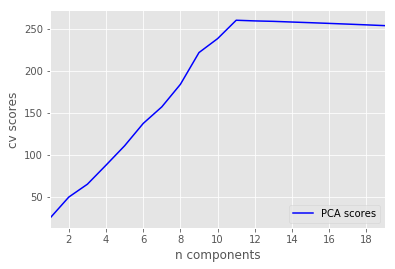

In [114]:
def plot_scores(d_scores):
    n_components = np.arange(1,np.array(d_scores).size+1)
    plt.plot(n_components, d_scores, 'b', label='PCA scores')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('cv scores')
    plt.legend(loc='lower right')
    plt.show()

d = []
for i in range(1,20):
    model = PCA(n_components=i)
    d.append(cv(model,X_train).mean())
plot_scores(d)